# Purpose:

2015-04-23 (Thursday)

Explore and characterize the results of ONLY the KG village.

# Contents
[Loading-files](#Loading-files)

[Filtering-Stats](#Filtering-Stats)

[Characterization-of-contigs-with/without-regard-to-selected-SNP-pairs](#Characterization-of-contigs-with/without-regard-to-selected-SNP-pairs)
- [All-contigs](#All-contigs)
- [All-SNP-pair-contigs](#All-SNP-pair-contigs)
- [LD-filtered-SNP-pair-contigs](#LD-filtered-SNP-pair-contigs)

[Compare-with-Tajima's-D-results-from-AndreaG](#Compare-with-Tajima's-D-results-from-AndreaG)
- [Examine-ld_contig_taj_win_filter](#Examine-ld_contig_taj_win_filter)
- [Basic-summary-table-referencing-SNP-pairs](#Basic-summary-table-referencing-SNP-pairs)
- [How-is-q-value-related-to-SNP-pair-distance?](#How-is-q-value-related-to-SNP-pair-distance?)
- [What-is-the-distribution-of-SNPs-per-bin-used-for-Tajima's-D-bin_50](#What-is-the-distribution-of-SNPs-per-bin-used-for-Tajima's-D-bin_50)
- [How-Tajima's-D-score-bin_50-relate-to-number-of-SNPs-in-the-bin](#How-Tajima's-D-score-bin_50-relate-to-number-of-SNPs-in-the-bin)

[Average-LD-per-bin](#Average-LD-per-bin)
- [All-contigs-together](#All-contigs-together)
- [5-random-contigs](#5-random-contigs)
- 

## Imports:

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm
import statsmodels.stats.multitest as smm

import munch

import pymc as mc

from spartan.utils.genome_specific.GfusI1 import GfusI1_0
from spartan.utils.fastas import ParseFastA

In [2]:
# set figure characteristics

# size
sns.set_context("talk")

# style
sns.set_style("whitegrid")

## Save plots?

In [3]:
save_plots = False

## File paths:

In [4]:
# define paths to files

base_out_dir = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld/KG"

fasta_path = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/assemblies/GfusI1/Glossina-fuscipes-IAEA_SCAFFOLDS_GfusI1.fa"
contig_name_length_path = "/home/gus/Dropbox/uganda_data/data_repos/genome_info/assembly_info/contig_name_length.csv"

ld_results_pickle="/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/SNPs/vcftools_out/ddrad58_populations/individuals/tsetseFINAL_14Oct2014_f2_53.recode.renamed_scaffolds.maf0_05.KG_indiv.geno.ld.pkl"


# tajimas_csv = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/Tajima50.csv"

# Record some info about the contigs once and for all

In [5]:
# contig_name_map = GfusI1_0.get_name_map_from_fasta_headers(fasta_path)

In [6]:
# contig_lengths = {}
# contigs = ParseFastA(fasta_path).to_dict()
# for name,seq in contigs.iteritems():
#     contig_lengths[name] = len(seq)

In [7]:
# # record both names and the length

# with open(contig_name_length_path,'w') as out:
#     template = "{kk_name},{scaf_name},{length}\n"
#     out.write(template.format(kk_name="kk_name",scaf_name="scaf_name",length="length"))
    
#     for kk_name, length in contig_lengths.iteritems():
#         out.write(template.format(kk_name=kk_name,
#                                   scaf_name=contig_name_map[kk_name],
#                                   length=length))
    

# Helper functions

In [20]:
def recode_taj_chrom(df):
    recode_func = lambda x: x.split(':')[-1]

    CHROM = df.CHROM.apply(recode_func)
    df.CHROM = CHROM
    
    
def save_figs(base_dir, fname, save_types=('png','pdf','svg'), is_ggplot=False):
    assert (is_ggplot is False) or isinstance(is_ggplot,gp.ggplot)
    
    if not save_plots:
        print "WARNING: 'save_plots' set to False."
        return None
    
    path = "{pth}.{{ext}}".format(pth=os.path.join(base_dir,fname))
    
    for t in save_types:
        
        if is_ggplot:
            gp.ggsave(path.format(ext=t),plot=is_ggplot)
        else:
            plt.savefig(path.format(ext=t), bbox_inches='tight')
            print "Saved {0}.".format(path.format(ext=t))


# Loading files

In [9]:
# load our results tables
ld = pd.read_pickle(ld_results_pickle)
ld.head()

,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,Scaffold0,13388,23408,3,NaN,10020,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Scaffold0,13388,23418,3,NaN,10030,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Scaffold0,13388,23421,3,NaN,10033,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Scaffold0,13388,23431,3,NaN,10043,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Scaffold0,13388,30544,3,NaN,17156,17150,NaN,NaN,NaN,NaN,NaN,NaN,False


In [10]:
contig_info = pd.read_csv(contig_name_length_path)
contig_info.head()

,kk_name,scaf_name,length
0,KK352346.1,Scaffold566,193315
1,KK352610.1,Scaffold839,83110
2,KK352241.1,Scaffold458,243873
3,JFJR01012964.1,JFJR01012964.1,3083
4,KK352052.1,Scaffold268,427914


In [11]:
# taj50 = pd.read_csv(tajimas_csv, sep='\t')
# taj50.head()

In [12]:
# recode_taj_chrom(taj50)
# taj50.head()

# Look at many distance_bin areas

In [18]:
def plot_bin_dists(df, bin_def="distance_bin <= 500"):
    
    g = sns.FacetGrid(data=df.query(bin_def), 
                      col="distance_bin",
                      sharey=False,
                      sharex=False,
                      col_wrap=4,
                     )
    
    
    return g.map(plt.hist, "R2", color="coral");
    

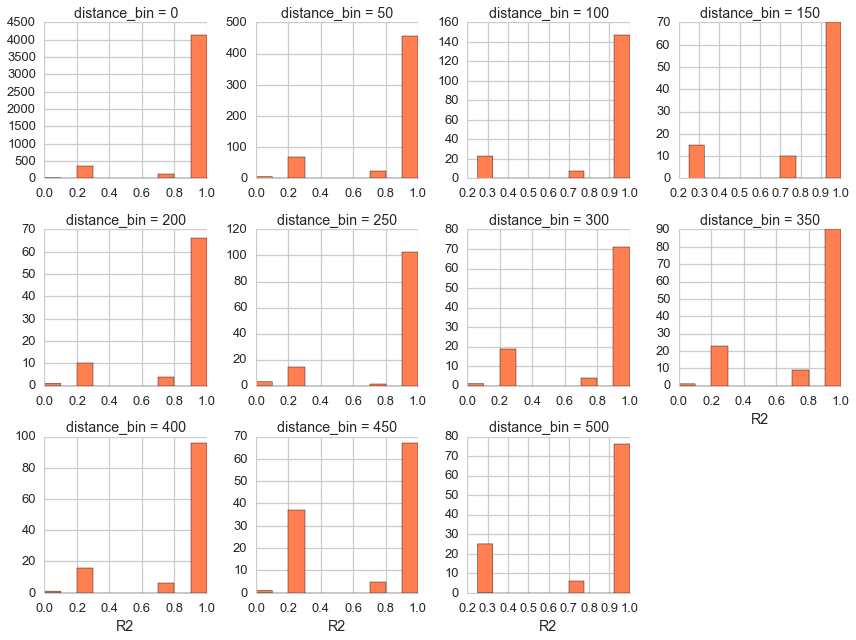

In [22]:
fname = "distance_bins_0_500"

p = plot_bin_dists(ld, bin_def="distance_bin <= 500")
    
p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

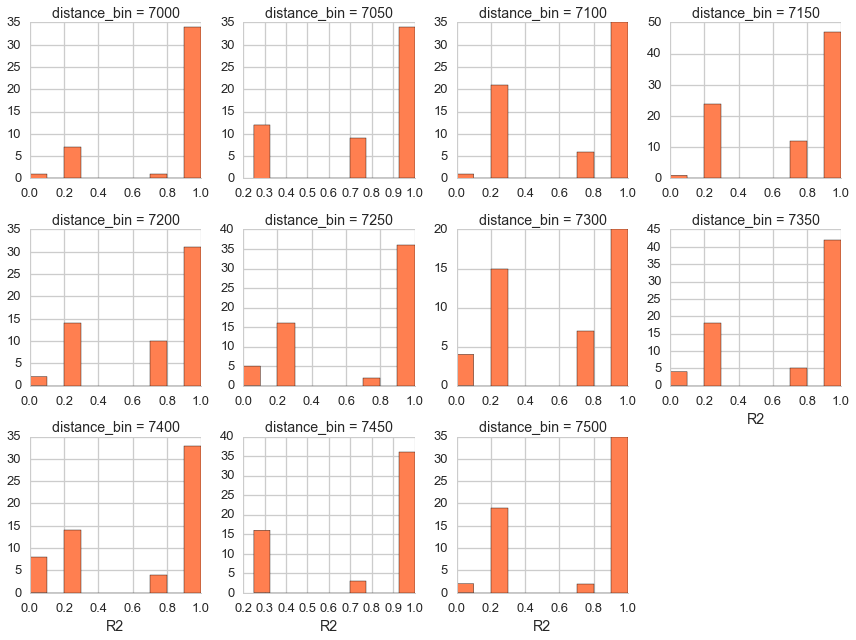

In [23]:
fname = "distance_bins_7000_7500"

p = plot_bin_dists(ld, bin_def="7000 <= distance_bin <= 7500")
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

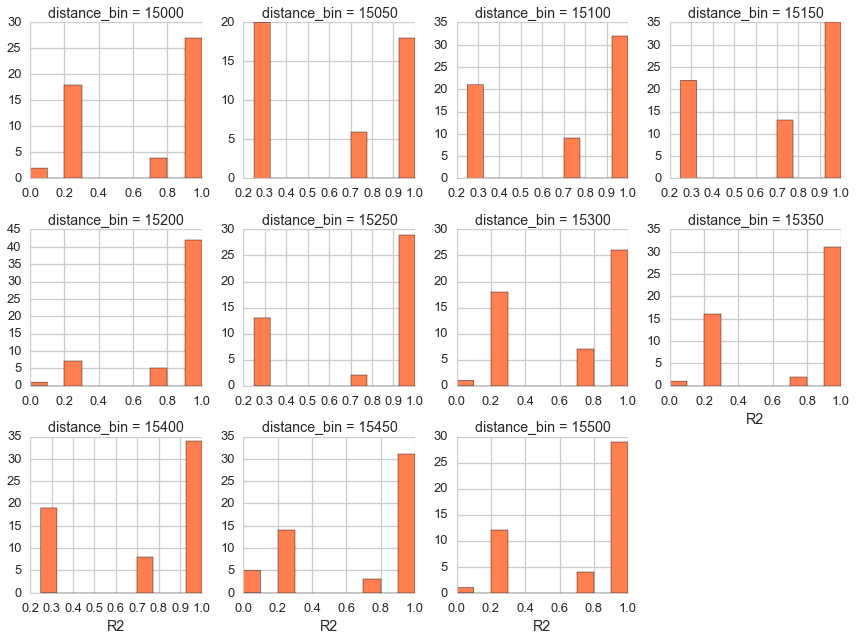

In [24]:
fname = "distance_bins_15000_15500"

p = plot_bin_dists(ld, bin_def="15000 <= distance_bin <= 15500")
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

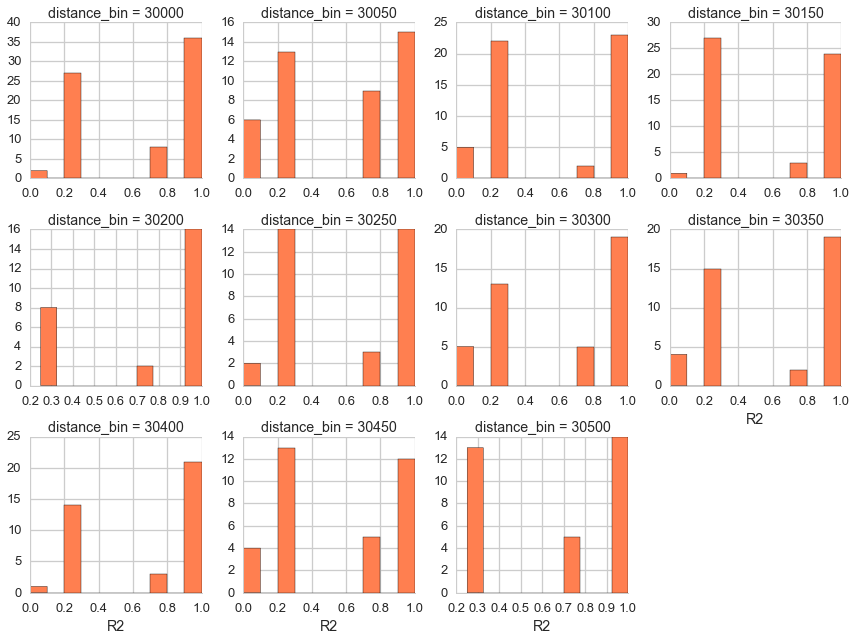

In [25]:
fname = "distance_bins_30000_30500"

p = plot_bin_dists(ld, bin_def="30000 <= distance_bin <= 30500")

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

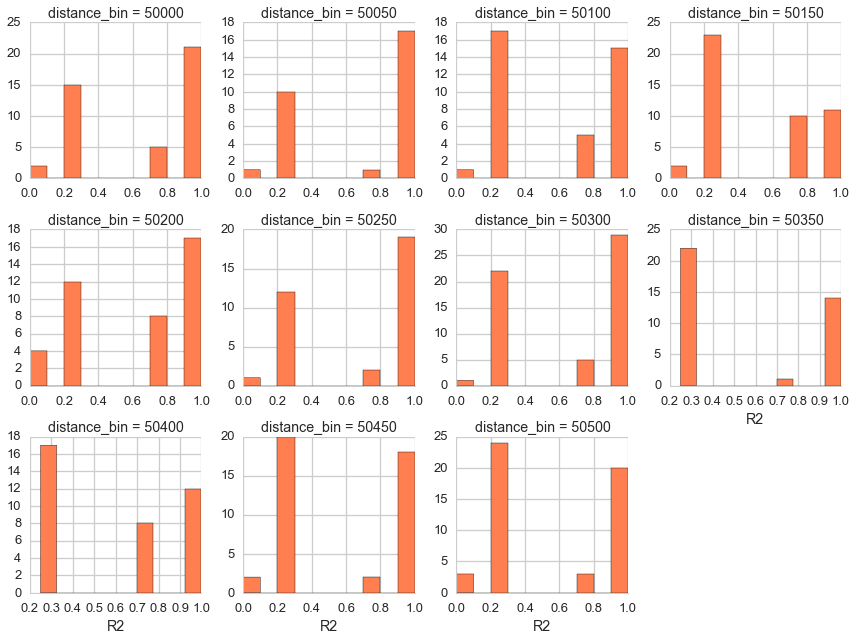

In [26]:
fname = "distance_bins_50000_50500"

p = plot_bin_dists(ld, bin_def="50000 <= distance_bin <= 50500")

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

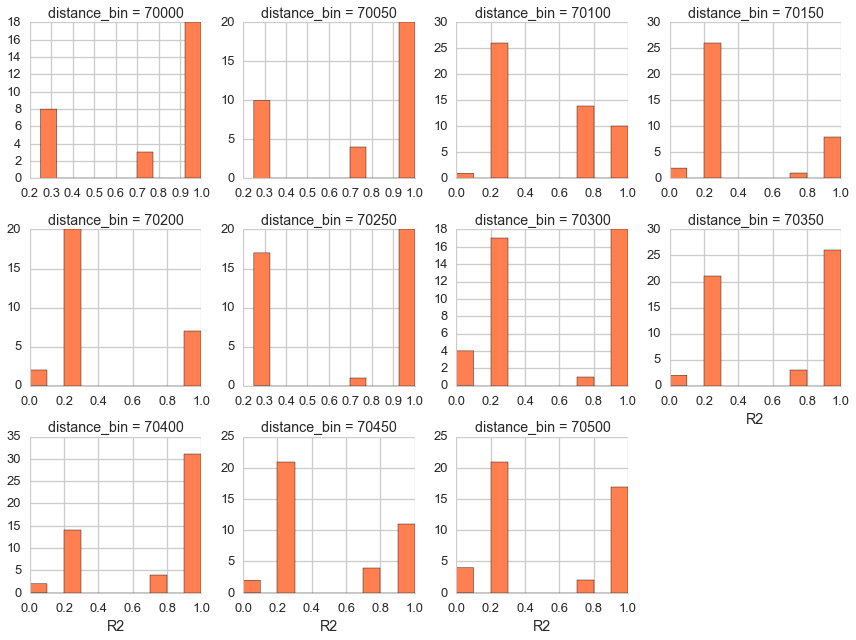

In [27]:
fname = "distance_bins_70000_70500"

p = plot_bin_dists(ld, bin_def="70000 <= distance_bin <= 70500")

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

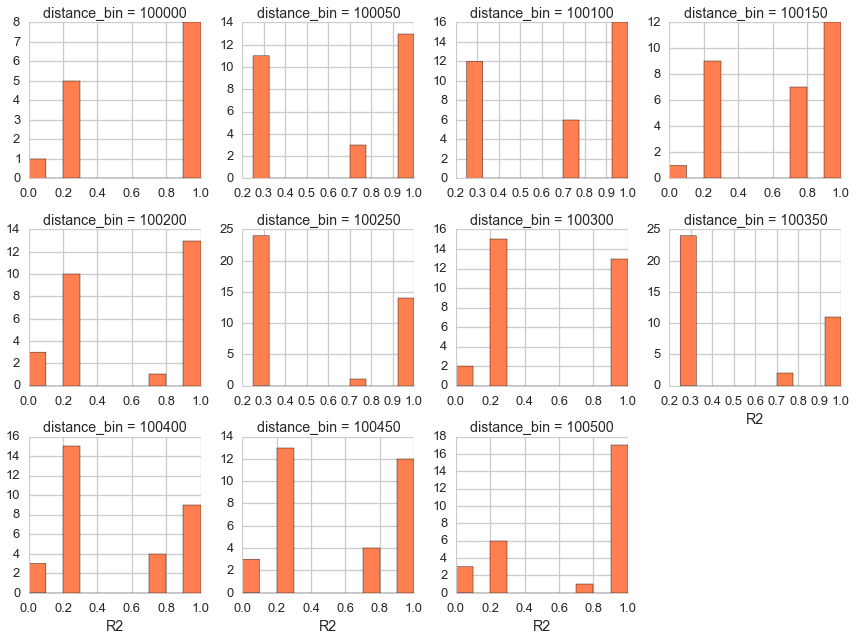

In [28]:
fname = "distance_bins_100000_100500"

p = plot_bin_dists(ld, bin_def="100000 <= distance_bin <= 100500")
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=False
         )

## Characterization of contigs with/without regard to selected SNP-pairs

In [29]:
# join contig length and kk_name contig info to the LD table
ld_contig = pd.merge(left=ld, right=contig_info, how='inner', left_on="CHR_A", right_on="scaf_name")
ld_contig.head()

,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,23408,3,NaN,10020,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,23418,3,NaN,10030,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,23421,3,NaN,10033,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,23431,3,NaN,10043,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,30544,3,NaN,17156,17150,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503


### All contigs

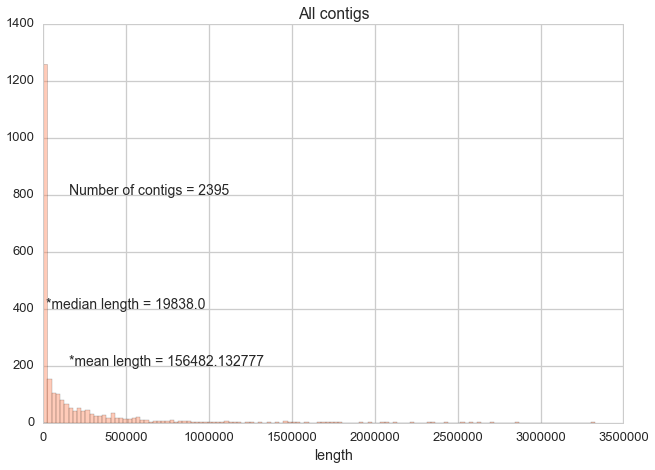

In [30]:
fname = "all_contig_len_dist"

sns.distplot(contig_info.length, color="coral", kde=0);
median_contig_len = contig_info.length.median()
mean_contig_len = contig_info.length.mean()
plt.text(median_contig_len,400,"*median length = {}".format(median_contig_len), fontsize=14);
plt.text(mean_contig_len,200,"*mean length = {}".format(mean_contig_len), fontsize=14);
plt.text(mean_contig_len,800,"Number of contigs = {}".format(len(contig_info)), fontsize=14);
plt.title("All contigs");

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','pdf','svg')
         )

### All SNP-pair contigs

In [31]:
sp_contigs = contig_info[contig_info.scaf_name.isin(ld_contig.scaf_name.unique())]
len(sp_contigs)

1276

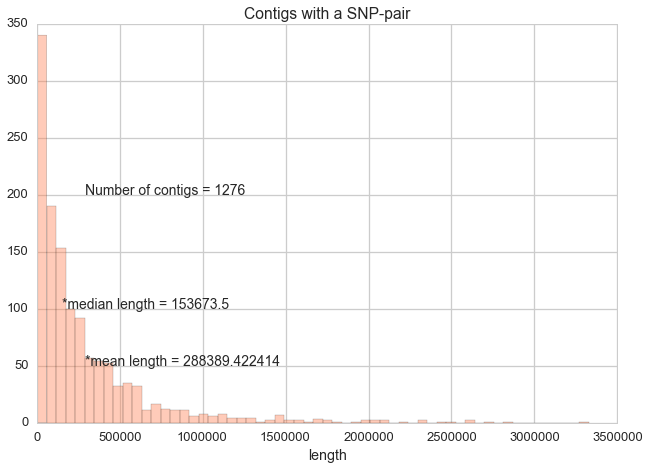

In [32]:
fname = "all_sp_contig_len_dist"

sns.distplot(sp_contigs.length, color="coral", kde=0);
sp_median_contig_len = sp_contigs.length.median()
sp_mean_contig_len = sp_contigs.length.mean()
plt.text(sp_median_contig_len,100,"*median length = {}".format(sp_median_contig_len), fontsize=14);
plt.text(sp_mean_contig_len,50,"*mean length = {}".format(sp_mean_contig_len), fontsize=14);
plt.text(sp_mean_contig_len,200,"Number of contigs = {}".format(len(sp_contigs)), fontsize=14);
plt.title("Contigs with a SNP-pair");

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','pdf','svg')
         )

### LD filtered SNP-pair contigs

In [33]:
ld_filt_contigs = ld_contig.query("one_minus_cdf_BH <= 0.01")
ld_filt_contigs = contig_info[contig_info.scaf_name.isin(ld_filt_contigs.scaf_name.unique())]
len(ld_filt_contigs)

0

In [35]:

################################################
## READ THIS NOW
##
## This fails bc there are ZERO SNP-pairs
##     that pass the filtering criteria
##
################################################

# fname = "filtered_sp_contig_len_dist"

# sns.distplot(ld_filt_contigs.length, color="coral", kde=0);
# ld_filt_median_contig_len = ld_filt_contigs.length.median()
# ld_filt_mean_contig_len = ld_filt_contigs.length.mean()
# plt.text(ld_filt_median_contig_len, 40, "*median length = {}".format(ld_filt_median_contig_len), fontsize=14);
# plt.text(ld_filt_mean_contig_len, 20, "*mean length = {}".format(ld_filt_mean_contig_len), fontsize=14);
# plt.text(ld_filt_mean_contig_len ,80, "Number of contigs = {}".format(len(ld_filt_contigs)), fontsize=14);
# plt.title(r"Contigs with a SNP-pair filtered by binned LD ($q \leq 0.01$)");

# save_figs(base_dir=base_out_dir, 
#           fname=fname, 
#           save_types=('png','pdf','svg')
#          )

## Compare with Tajima's D results from AndreaG

In [ ]:
# taj50.head()

In [ ]:
# ld_contig.head()

### To accomplish
Need to filter out `ld_contig` data that has either SNP ocurring in the bins defined by `taj50.CHROM:taj50.BIN_start-[taj50.BIN_start+50]`

First try:

- join INNER `ld_contig` and `taj50` on `left_on=kk_name`, `right_on=CHROM` as `ld_contig_taj`
- reatain those rows where `ld_contig_taj.BP_A` or `ld_contig_taj.BP_B` is inside `ld_contig_taj.BIN_start` - `ld_contig_taj.BIN_start+50`

In [ ]:
# ld_contig_taj = pd.merge(left=ld_contig, right=taj50, how='inner', left_on='kk_name', right_on='CHROM')

In [ ]:
# def get_taj_win_mask(df):
#     taj_win_start = df.BIN_start
#     taj_win_end = df.BIN_start + 50
    
#     a_mask = (ld_contig_taj.BIN_start <= ld_contig_taj.BP_A) & (ld_contig_taj.BP_A <= ld_contig_taj.BIN_start + 50)
#     b_mask = (ld_contig_taj.BIN_start <= ld_contig_taj.BP_B) & (ld_contig_taj.BP_B <= ld_contig_taj.BIN_start + 50)
    
#     return (a_mask | b_mask)

# # get all at first
# ld_contig_taj_win = ld_contig_taj[get_taj_win_mask(ld_contig_taj)]

# # now subset these to only rows that meet the LD bin filter
# ld_contig_taj_win_filter = ld_contig_taj_win.query("one_minus_cdf_BH <= 0.01")

In [ ]:
# print len(ld_contig_taj)
# print len(ld_contig_taj_win)
# print len(ld_contig_taj_win_filter)

In [ ]:
# ld_contig_taj_win_filter.head(15)

## Examine `ld_contig_taj_win_filter` 

### Basic summary table referencing SNP-pairs

In [ ]:
# ld_contig_taj_win_filter_t1 = pd.pivot_table(ld_contig_taj_win_filter,
#                                              index=['scaf_name','BP_A','BP_B','distance_bin'],
#                                              fill_value=0,
#                                             )
# ld_contig_taj_win_filter_t1.head()

### How is q-value related to SNP-pair distance?

In [ ]:
# sns.jointplot(x='BP_DELTA',
#               y='one_minus_cdf_BH', 
#               data=ld_contig_taj_win_filter, 
#               kind='reg',
#               color='lightblue',
#               xlim=(0,ld_contig_taj_win_filter.distance_bin.max()),
#               ylim=(0,ld_contig_taj_win_filter.one_minus_cdf_BH.max()));

### What is the distribution of SNPs per bin used for Tajima's D bin_50

In [ ]:
# sns.distplot(ld_contig_taj_win_filter.N_SNPs, color='lightblue', kde=0);

### How Tajima's D score bin_50 relate to number of SNPs in the bin

In [ ]:
# sns.jointplot(x='N_SNPs',
#               y='TajimaD', 
#               data=ld_contig_taj_win_filter, 
#               kind='reg',
#               color='lightblue',
#              );

# Average LD per bin

### How many contigs are available to each distance_bin?

In [36]:
def get_contigs_per_bin(d_bins,contig_info):
    
    cpb = {}
    
    for b in d_bins:
        cpb[b] = sum(contig_info.length > b)
        
    return pd.Series(cpb)

In [37]:
d_bins = ld_contig.distance_bin.unique()
d_bins.sort()
d_bins
# Generate a dict to map how many contigs avail to each bin
contigs_per_bin = get_contigs_per_bin(d_bins,contig_info)
contigs_per_bin

0          2395
50         2395
100        2395
150        2395
200        2395
250        2395
300        2395
350        2395
400        2395
450        2395
500        2395
550        2395
600        2395
650        2395
700        2395
750        2395
800        2395
850        2395
900        2394
950        2384
1000       2361
1050       2295
1100       2229
1150       2166
1200       2120
1250       2067
1300       2023
1350       1986
1400       1946
1450       1919
           ... 
3248250       1
3250950       1
3252550       1
3255350       1
3255400       1
3257100       1
3257500       1
3257600       1
3257700       1
3258500       1
3259650       1
3260600       1
3264200       1
3264250       1
3264600       1
3264750       1
3264800       1
3264850       1
3265400       1
3265600       1
3267700       1
3267750       1
3269700       1
3274250       1
3274300       1
3274650       1
3274800       1
3274850       1
3275650       1
3277750       1
dtype: int64

In [38]:
contigs_per_bin = pd.DataFrame(contigs_per_bin,columns=['contigs_per_bin'])

In [39]:
contigs_per_bin = contigs_per_bin.reset_index().rename(columns={'index':'distance_bin'}, inplace=False)

In [40]:
contigs_per_bin.head()

,distance_bin,contigs_per_bin
0,0,2395
1,50,2395
2,100,2395
3,150,2395
4,200,2395


### Set plotting style for "scatter with line" type figure

In [41]:
def plot_scat_w_line(gp_aes):
    return gp_aes + \
           gp.geom_point(color='coral') + \
           gp.stat_smooth(span=.2, color='blue', se=False) + \
           gp.theme_seaborn(context='talk')


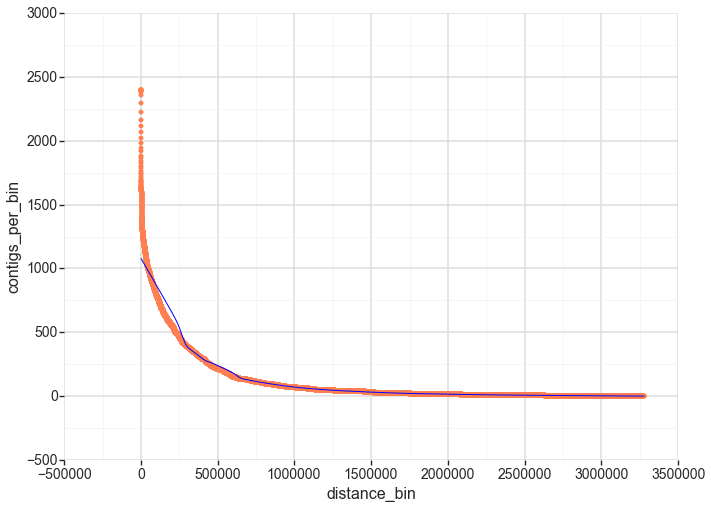

<ggplot: (8743380585677)>


In [42]:
fname = "distance_VS_contigs_per_bin"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='contigs_per_bin'), data=contigs_per_bin))
    
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )

## All contigs together

In [43]:
ld_contig.head()

,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,23408,3,NaN,10020,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,23418,3,NaN,10030,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,23421,3,NaN,10033,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,23431,3,NaN,10043,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,30544,3,NaN,17156,17150,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503


In [44]:
mean_bin_r2_all = ld_contig.groupby("distance_bin").mean().reset_index()

In [45]:
median_bin_r2_all = ld_contig.groupby("distance_bin").median().reset_index()

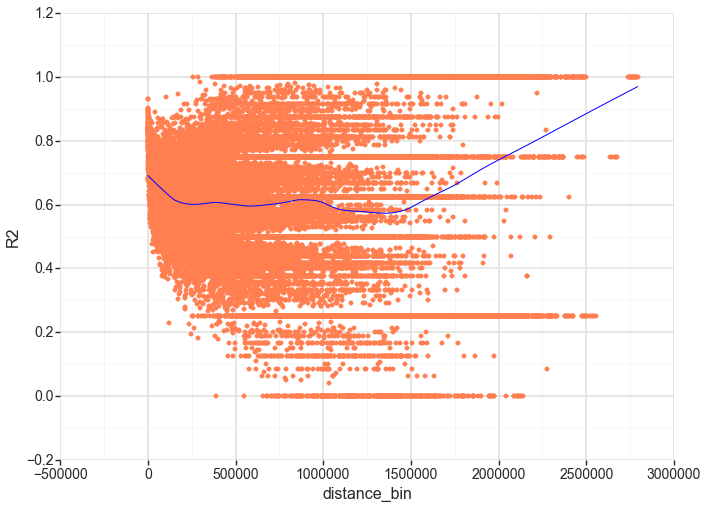

<ggplot: (8743380994869)>


In [46]:
fname = "distance_VS_r2_all"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin >= 0")))

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )

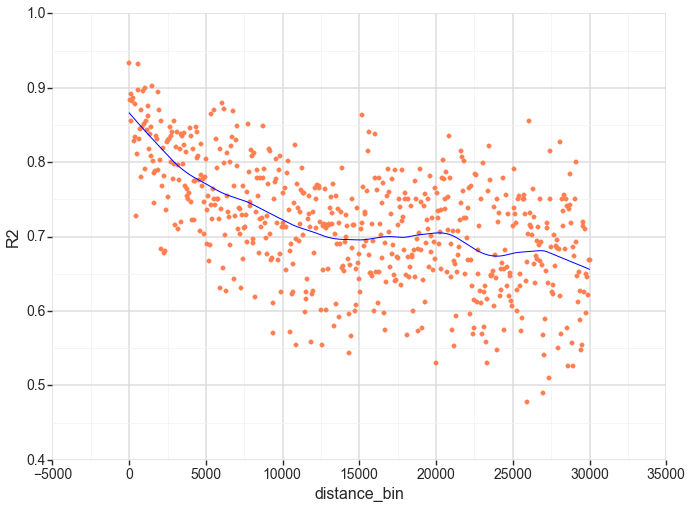

<ggplot: (8743381451901)>


In [47]:
fname = "distance_VS_r2_le30K"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 30000")))
  
print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    
    

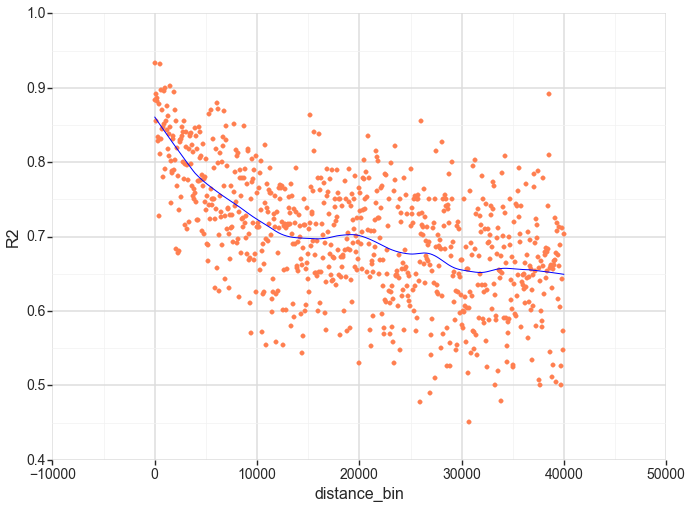

<ggplot: (8743380569261)>


In [48]:
fname = "distance_VS_r2_le40K"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 40000")))

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    
    

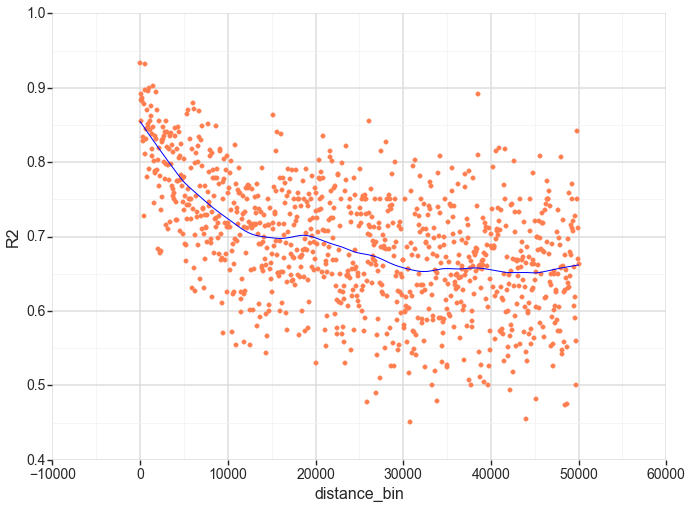

<ggplot: (8743379925685)>


In [49]:
fname = "distance_VS_r2_le50K"

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 50000")))

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    
    

In [50]:
len(ld_contig)

6454294

In [51]:
len_contigs_per_bin = ld_contig.pivot_table(index=['distance_bin'], 
                                            values=['scaf_name'],
                                            aggfunc=[len]
                                           )['len'].reset_index()

len_contigs_per_bin = len_contigs_per_bin.rename(columns={'scaf_name':'SNP-pairs'}, inplace=False)
len_contigs_per_bin.head()

,distance_bin,SNP-pairs
0,0,36566
1,50,4274
2,100,2010
3,150,1204
4,200,1159


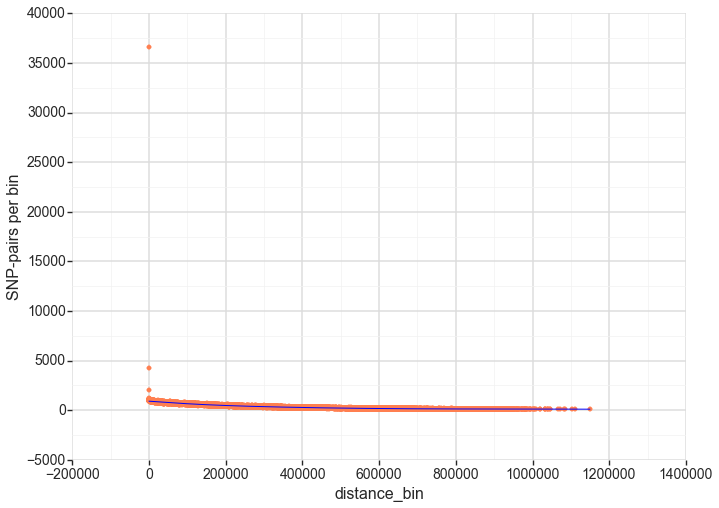

<ggplot: (8743380113089)>


In [52]:
fname = "distance_VS_sp_per_bin_gt100"

sp_gt100mask = len_contigs_per_bin["SNP-pairs"] > 100

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', 
                                  y='SNP-pairs'), 
                           data=len_contigs_per_bin[sp_gt100mask])
                ) + gp.ylab('SNP-pairs per bin')

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    


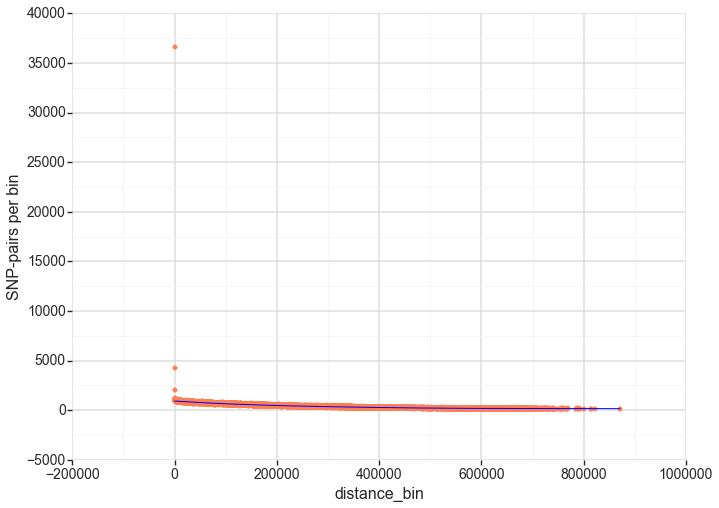

<ggplot: (8743379900505)>


In [53]:
fname = "distance_VS_sp_per_bin_gt150"

sp_gt150mask = len_contigs_per_bin["SNP-pairs"] > 150

p = plot_scat_w_line(gp.ggplot(gp.aes(x='distance_bin', 
                                  y='SNP-pairs'), 
                           data=len_contigs_per_bin[sp_gt150mask])
                ) + gp.ylab('SNP-pairs per bin')

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )    


In [54]:
ld_contig.head()

,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,23408,3,NaN,10020,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,23418,3,NaN,10030,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,23421,3,NaN,10033,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,23431,3,NaN,10043,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,30544,3,NaN,17156,17150,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503


In [55]:
d_bin_v_others = ld_contig.pivot_table(index=['distance_bin'], 
                                        values=['R2','one_minus_cdf_BH'],
                                        aggfunc=[np.mean]
                                       )['mean'].reset_index()
d_bin_v_others.head()

,distance_bin,R2,one_minus_cdf_BH
0,0,0.932564,NaN
1,50,0.883961,NaN
2,100,0.891854,NaN
3,150,0.855263,NaN
4,200,0.882716,NaN


In [56]:
d_bin_v_others = d_bin_v_others.merge(right=len_contigs_per_bin, 
                     how='inner', 
                     on='distance_bin'
                     ).merge(right=contigs_per_bin, 
                             how='inner', 
                             on='distance_bin'
                            )
d_bin_v_others.head()

,distance_bin,R2,one_minus_cdf_BH,SNP-pairs,contigs_per_bin
0,0,0.932564,NaN,36566,2395
1,50,0.883961,NaN,4274,2395
2,100,0.891854,NaN,2010,2395
3,150,0.855263,NaN,1204,2395
4,200,0.882716,NaN,1159,2395


In [57]:
d_bin_v_others_melt = pd.melt(d_bin_v_others, id_vars=['distance_bin'])

In [58]:
d_bin_v_others_melt.head()

,distance_bin,variable,value
0,0,R2,0.932564
1,50,R2,0.883961
2,100,R2,0.891854
3,150,R2,0.855263
4,200,R2,0.882716


IndexError: index out of bounds

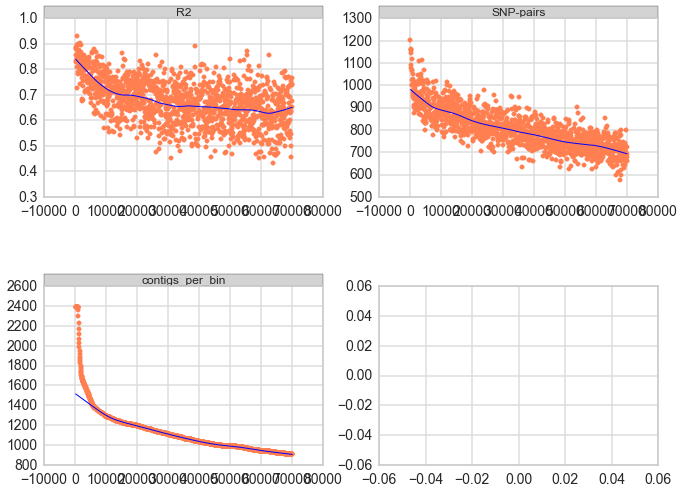

In [59]:
xmin = 150
xmax = 70000

fname = "distance_VS_avgR2_spperbin_contigsperbin_q_b{bmin}-to-b{bmax}".format(
    bmin=xmin,
    bmax=xmax
    )

p = plot_scat_w_line(
    gp.ggplot(
        gp.aes(
            x='distance_bin', y='value'
        ), 
        data=d_bin_v_others_melt.query(
            "{xmin} <= distance_bin <= {xmax}".format(
                xmin=xmin,
                xmax=xmax
            )
        )
    )
) + \
gp.facet_wrap("variable") + \
gp.ggtitle(fname)

print p

save_figs(base_dir=base_out_dir, 
          fname=fname, 
          save_types=('png','svg'),
          is_ggplot=p
         )


In [60]:
# g = sns.PairGrid(d_bin_v_others.loc[:,["R2", "one_minus_cdf_BH",    "SNP-pairs",   "contigs_per_bin",]])
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_diag(sns.kdeplot, lw=3, legend=False)
d_bin_vars = d_bin_v_others.loc[:,["R2", "one_minus_cdf_BH",    "SNP-pairs",   "contigs_per_bin",]]

In [61]:
d_bin_vars.head()

,R2,one_minus_cdf_BH,SNP-pairs,contigs_per_bin
0,0.932564,NaN,36566,2395
1,0.883961,NaN,4274,2395
2,0.891854,NaN,2010,2395
3,0.855263,NaN,1204,2395
4,0.882716,NaN,1159,2395


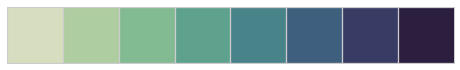

In [62]:
sns.palplot(sns.cubehelix_palette(8, start=.5, rot=-.75))

In [63]:
my_cmap=sns.cubehelix_palette(40, start=.5, rot=-.75, as_cmap=True)
cc = sns.mpl.colors.ColorConverter()
marginal_color = cc.to_rgb(arg=my_cmap.colors[int(255*1)])

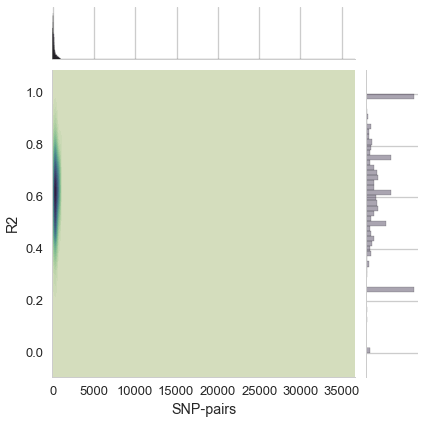

In [64]:
# sns.jointplot('SNP-pairs','R2',d_bin_vars, kind='kde',
#               joint_kws=dict(shade=True,
#                              cmap=my_cmap,
#                              n_levels=40
#                             ),
#               marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
#              )

g = sns.JointGrid('SNP-pairs','R2',d_bin_vars)
g.plot_marginals(sns.distplot, kde=False, color=marginal_color)
g.plot_joint(sns.kdeplot, shade=True, cmap=my_cmap, n_levels=40);

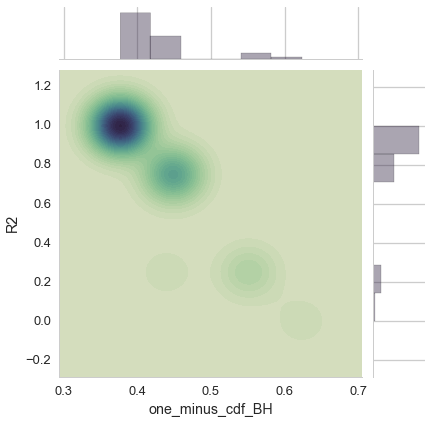

In [ ]:
# sns.jointplot('one_minus_cdf_BH','R2',d_bin_vars, kind='kde',
#               joint_kws=dict(shade=True,
#                              cmap=my_cmap,
#                              n_levels=40
#                             ),
#               marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
#              )

g = sns.JointGrid('one_minus_cdf_BH','R2',d_bin_vars)
g.plot_marginals(sns.distplot, kde=False, color=marginal_color)
g.plot_joint(sns.kdeplot, shade=True, cmap=my_cmap, n_levels=40, alpha=1);

In [ ]:
sns.jointplot('contigs_per_bin','SNP-pairs',d_bin_vars, kind='kde',
              joint_kws=dict(shade=True,
                             cmap=my_cmap,
                             n_levels=8
                            ),
              marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
             )